In [6]:
!pip install umap-learn

     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 32.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=8d877be8894977cdca6cdaa6e023a5064a9946929c2234f48fafdd7d55a1198c
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=480a487298f4aa2ab445a72a56963d362c83c18adca9afee195ed8547eda5abc
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [7]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from tqdm.auto import tqdm ,trange
import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import pandas as pd


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [10]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [11]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [12]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [13]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [14]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [15]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

In [16]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [17]:
training_loader = DataLoader(training_data, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)

In [18]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [19]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [20]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [21]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [22]:
train_res_recon_error = []
train_res_perplexity = []
train_vq_loss = []
train_loss = []
val_res_recon_error = []
val_res_perplexity = []
val_vq_loss = []
val_loss = []
epochs = 40
for epoch in trange(epochs):
    res_recon_error_running = 0
    res_perplexity_running = 0
    vq_loss_running = 0
    loss_running = 0
    model.train()
    print("training")
    for data,_ in tqdm(training_loader,leave = False):
        data = data.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(data)
        recon_error = F.mse_loss(data_recon, data) 
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
        res_recon_error_running += recon_error.item()
        res_perplexity_running += perplexity.item()
        loss_running += loss.item()
        vq_loss_running += vq_loss.item()
        

    res_recon_error_running /=len(training_loader)
    res_perplexity_running /=len(training_loader)
    loss_running /=len(training_loader)
    vq_loss_running /=len(training_loader)
    train_res_recon_error.append(res_recon_error_running)
    train_res_perplexity.append(res_perplexity_running)
    train_vq_loss.append(vq_loss_running)
    train_loss.append(loss_running)
    log = {"epoch": [epoch+1],"recon_error":[res_recon_error_running]
           ,"perplexity":[res_perplexity_running],
           "vq_loss":[vq_loss_running],"loss":[loss_running]}
    log = pd.DataFrame(log)
    print(log)
    
    print("validation")
    res_recon_error_running = 0
    res_perplexity_running = 0
    vq_loss_running = 0
    loss_running = 0
    model.eval()
    with torch.no_grad():
        for data,_ in tqdm(validation_loader,leave = False):
            data = data.to(device)


            vq_loss, data_recon, perplexity = model(data)
            recon_error = F.mse_loss(data_recon, data) 
            loss = recon_error + vq_loss
            

            
            res_recon_error_running += recon_error.item()
            res_perplexity_running += perplexity.item()
            loss_running += loss.item()
            vq_loss_running += vq_loss.item()
    res_recon_error_running /=len(training_loader)
    res_perplexity_running /=len(training_loader)
    loss_running /=len(training_loader)
    vq_loss_running /=len(training_loader)
    val_res_recon_error.append(res_recon_error_running)
    val_res_perplexity.append(res_perplexity_running)
    val_vq_loss.append(vq_loss_running)
    val_loss.append(loss_running)
    log = {"epoch": [epoch+1],"recon_error":[res_recon_error_running]
           ,"perplexity":[res_perplexity_running],
           "vq_loss":[vq_loss_running],"loss":[loss_running]}
    log = pd.DataFrame(log)
    print(log)
    print("_________________________________________________________________")

  0%|          | 0/40 [00:00<?, ?it/s]

training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      1     0.062561         1.0  0.020445  0.083006
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      1     0.098739    1.596939  0.021158  0.119897
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      2     0.062053         1.0  0.017623  0.079676
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      2     0.098732    1.596939  0.018636  0.117368
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      3     0.061991         1.0  0.020144  0.082135
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity  vq_loss      loss
0      3     0.098695    1.596939  0.03741  0.136104
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      4     0.049963    1.641078  0.013928  0.063891
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      4     0.033321    5.512603  0.008721  0.042043
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      5     0.013255   11.594479  0.002796  0.016052
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      5     0.015392   29.799952  0.002413  0.017805
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      6     0.008675   26.018192  0.001671  0.010346
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      6     0.012472   48.564579  0.002709  0.015181
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      7     0.007356   35.280169  0.001767  0.009123
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      7      0.01117   60.171284  0.002855  0.014024
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      8     0.006743   45.098403  0.001755  0.008498
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      8     0.010733   76.581537  0.002764  0.013497
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      9     0.006348   55.218161  0.001834  0.008182
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0      9     0.009773   92.038627  0.003126  0.012898
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     10     0.006007   65.704511  0.001925  0.007931
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     10     0.009314  108.985573  0.002881  0.012194
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity  vq_loss      loss
0     11     0.005712    78.44893  0.00179  0.007502
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity  vq_loss      loss
0     11     0.009077  126.263469  0.00273  0.011807
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     12     0.005444   94.485665  0.001651  0.007095
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     12     0.008517   154.48825  0.002539  0.011056
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     13     0.005229  110.847335  0.001582  0.006812
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     13     0.008239  176.154675  0.002536  0.010775
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     14     0.005019  127.617941  0.001599  0.006618
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     14     0.007815  201.277026  0.002557  0.010372
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     15     0.004856  144.907083  0.001589  0.006445
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     15     0.007521  228.031435  0.002464  0.009985
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     16      0.00468  164.528476  0.001547  0.006227
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     16      0.00744  251.533779  0.002407  0.009847
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     17     0.004554  182.951272  0.001501  0.006055
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     17     0.007181  275.688243  0.002394  0.009574
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     18     0.004435  202.791178  0.001457  0.005892
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss     loss
0     18     0.006974  306.152625  0.002296  0.00927
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     19     0.004333  223.293155  0.001429  0.005762
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     19     0.006787  331.403382  0.002269  0.009056
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     20     0.004231  244.233475  0.001466  0.005697
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     20     0.006671  354.639403  0.002397  0.009068
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     21     0.004149  263.428765  0.001533  0.005681
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     21      0.00656  376.607982  0.002438  0.008998
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     22     0.004049  280.895654  0.001554  0.005603
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     22     0.006385   401.52663  0.002503  0.008888
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     23     0.003983  299.317643  0.001562  0.005545
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     23     0.006324   421.12432  0.002509  0.008833
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss     loss
0     24     0.003913  316.843348  0.001567  0.00548
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     24     0.006187  444.223644  0.002531  0.008718
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     25     0.003848  335.682563  0.001568  0.005416
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     25     0.006072  465.993957  0.002515  0.008587
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     26     0.003791  352.137158  0.001564  0.005356
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     26     0.006064   482.83986  0.002485  0.008549
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss     loss
0     27     0.003745   369.55488  0.001576  0.00532
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     27     0.005896   505.53914  0.002501  0.008397
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     28     0.003698   384.33354  0.001625  0.005322
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     28     0.005918  519.509033  0.002679  0.008597
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss     loss
0     29     0.003654   393.52011  0.001686  0.00534
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss     loss
0     29     0.005754  523.135578  0.002706  0.00846
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss     loss
0     30     0.003616  396.247148  0.001714  0.00533
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     30     0.005756  524.675213  0.002722  0.008478
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     31     0.003598  397.449537  0.001731  0.005329
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss    loss
0     31     0.005736  525.561875  0.002764  0.0085
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     32     0.003572   398.13388  0.001755  0.005327
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     32     0.005709  523.639907  0.002787  0.008496
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     33     0.003546  399.068984  0.001774  0.005319
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     33     0.005682  525.988797  0.002817  0.008498
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     34     0.003543  398.979798  0.001784  0.005327
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     34      0.00563  528.483176  0.002886  0.008516
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss     loss
0     35     0.003516  399.024273  0.001804  0.00532
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     35     0.005637  525.971292  0.002908  0.008545
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     36     0.003502  399.230193  0.001819  0.005322
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     36     0.005768  526.977887  0.002876  0.008645
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     37     0.003486  399.123506  0.001828  0.005313
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     37     0.005619   527.03014  0.002911  0.008531
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     38     0.003478  398.709812  0.001838  0.005316
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss     loss
0     38     0.005614   525.60879  0.002956  0.00857
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity  vq_loss     loss
0     39      0.00347  398.339344  0.00185  0.00532
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     39     0.005554  524.830574  0.002961  0.008515
_________________________________________________________________
training


  0%|          | 0/196 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     40     0.003473  397.886081  0.001856  0.005329
validation


  0%|          | 0/313 [00:00<?, ?it/s]

   epoch  recon_error  perplexity   vq_loss      loss
0     40     0.005569   525.28309  0.002947  0.008516
_________________________________________________________________


## Plot Loss

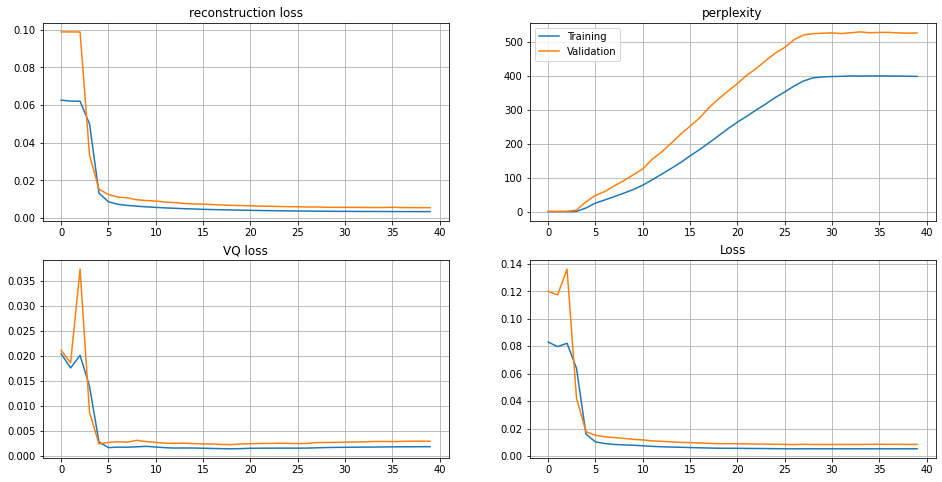

In [23]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(train_res_recon_error,label= "Training")
plt.plot(val_res_recon_error,label= "Validation")
plt.title("reconstruction loss")
plt.grid("on")
plt.subplot(2,2,2)
plt.plot(train_res_perplexity,label= "Training")
plt.plot(val_res_perplexity,label= "Validation")
plt.title("perplexity")
plt.grid("on")
plt.legend()
plt.subplot(2,2,3)
plt.plot(train_vq_loss,label= "Training")
plt.plot(val_vq_loss,label= "Validation")
plt.title("VQ loss")
plt.grid("on")
plt.subplot(2,2,4)
plt.plot(train_loss,label= "Training")
plt.plot(val_loss,label= "Validation")
plt.title("Loss")
plt.grid("on")

## View Reconstructions

In [24]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [25]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [26]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


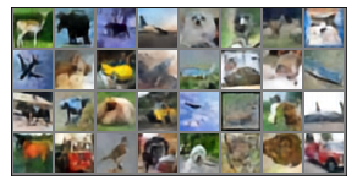

In [27]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

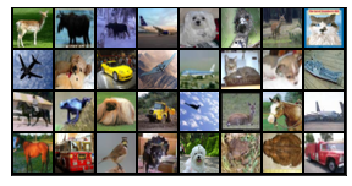

In [28]:
show(make_grid(valid_originals.cpu()+0.5))

In [30]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


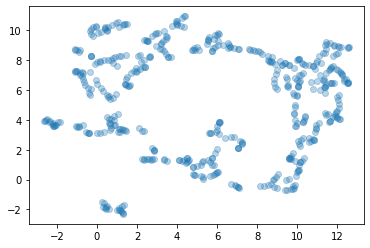

In [31]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

(512, 2)